# Basics - Hooks in PyTorch
By [Akshaj Verma](https://akshajverma.com/)

This notebook takes you through the implementation of hooks in PyTorch through an example of multiclass classification using feedforward networks on the IRIS dataset.

## Import Libraries and Enable GPU

https://open.spotify.com/track/7CmU7JYRrW3AVko82AnZgo?si=NlwFNSjtQ_i4bS9aIw3BNg

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
torch.manual_seed(69)
np.random.seed(21)

In [3]:
%matplotlib inline
sns.set_style('darkgrid')

print("We're using cuda?", torch.cuda.is_available())

We're using cuda? True


In [4]:
df = pd.read_csv("../../data/tabular/classification/iris.csv")

## Pre-processing

In [5]:
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


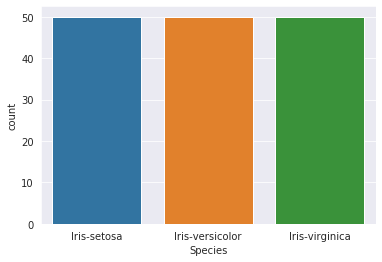

In [9]:
sns.countplot(x = 'Species', data=df)

To do that, let's create a dictionary called `class2idx` and use the `.replace()` method from the Pandas library to change it. Let's also create a reverse mapping called `idx2class` which converts the IDs back to their original classes.


To create the reverse mapping, we create a dictionary comprehension and simply reverse the key and value.

In [10]:
# PyTorch supports labels starting from 0. That is [0, n]. We need to remap our labels to start from 0.

class2idx = {
    "Iris-setosa": 0,
    "Iris-versicolor": 1,
    "Iris-virginica": 2
    
}

idx2class = {v: k for k, v in class2idx.items()}

df['Species'].replace(class2idx, inplace=True)

In order to split our data into train, validation, and test sets, we need to separate out our inputs and outputs. 


Input X is all but the last column. Output y is the last column.

In [11]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

## Train - Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

In [14]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

## Neural Net

### Define Custom Dataset

First up, let's define a custom dataset. This dataset will be used by the dataloader to pass our data into our model.   
We initialize our dataset by passing `X` and `y` as inputs. Make sure `X` is a `float` while `y` is `long`.

In [16]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

### Model Params

Before we proceed any further, let's define a few parameters that we'll use down the line.

In [17]:
EPOCHS = 1
BATCH_SIZE = 5
LEARNING_RATE = 0.001

NUM_FEATURES = len(X.columns)
NUM_CLASSES = df['Species'].nunique()

### Define Dataloader

Let's now initialize our dataloaders. 

For `train_dataloader` we'll use `batch_size = 5` with `shuffle=True`. 

For `test_dataloader` we'll use `batch_size = 1`.

In [19]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

## Define Neural Net Architecture

Let's define a simple feedforward network. 

`(input) 4 => 10 => 12 => 14 => 3(outupt)`

In [35]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 10)
        self.layer_2 = nn.Linear(10, 12)
        self.layer_3 = nn.Linear(12, 14)
        self.layer_out = nn.Linear(14, num_class) 
        
        self.relu = nn.ReLU()
        
        self.lmao = None
        
    def access_gradients(self, grad):
        return torch.clamp(grad, min = 0)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.relu(x)
        
        x = self.layer_3(x)
        x = self.relu(x)
        
        if self.train and x.requires_grad: x.register_hook(self.access_gradients)
  
        x = self.layer_out(x)
        
        return x

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [37]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

MulticlassClassification(
  (layer_1): Linear(in_features=4, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=12, bias=True)
  (layer_3): Linear(in_features=12, out_features=14, bias=True)
  (layer_out): Linear(in_features=14, out_features=3, bias=True)
  (relu): ReLU()
)


## Train 

Before we start our training, let's define a function to calculate accuracy per epoch. 

This function takes y_pred and y_test as input arguments. We then apply softmax to  y_pred and extract the class which has a higher probability.

After that, we compare the the predicted classes and the actual classes to calculate the accuracy.

In [38]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

In [39]:
print("Begin training.")

for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0

    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()  
                     
    
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}')

Begin training.


Epoch 01: | Train Loss: 1.11018 | Train Acc: 12.500



In [40]:
model.layer_3.weight.grad.shape

torch.Size([14, 12])

AttributeError: 'NoneType' object has no attribute 'shape'